In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def sigmoid(x):
    x = np.clip(x, -10, 10)
    return 1 / (1 + np.exp(-x))

def tanh(x):
    x = np.clip(x, -10, 10)
    return 2 / (1 + np.exp(-x)) - 1

def relu_grad_activation(x):
    return x > 0

def leaky_relu_grad_activation(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)
    
def sigmoid_grad_activation(x):
    return x * (1 - x)

def tanh_grad_activation(x):
    return 1 - x**2

def softmax(x):
    x = np.clip(x, -10, 10)
    x -= np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-8)


def identity(x):
    return x

def xavier_initialize(shape):
    fan_in, fan_out = shape
    limit = np.sqrt(6. / (fan_in + fan_out))  # Range for uniform distribution
    return np.random.uniform(-limit, limit, size=shape)

def he_initialize(shape):
    fan_in, _ = shape
    stddev = np.sqrt(2. / fan_in)  # Standard deviation for normal distribution
    return np.random.randn(*shape) * stddev

def uniform_initialize(shape):
    return np.random.uniform(low=-1.0, high=1.0, size=shape)

def clip_gradients(grad, max_norm=5.0):
    grad_copy = grad.copy()
    norm = np.linalg.norm(grad_copy) + 1e-8
    if norm > max_norm:
        grad_copy *= max_norm / norm
    return grad_copy

def accuracy(y_hat, y):
    return np.mean(y_hat.reshape(1, -1) == y.reshape(1, -1))

def one_hot_encode_classes(y, num_classes):
    return np.eye(num_classes)[y]

def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / y_true.shape[0]

def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def check_nan_inf(*arrays):
    for arr in arrays:
        assert not np.any(np.isnan(arr)), "NaN detected"
        assert not np.any(np.isinf(arr)), "Inf detected"


In [18]:
def Update_LSTM_Weights(model, dUi, dUf, dUo, dUg,
                               dWi, dWf, dWo, dWg, dW,
                               dbi, dbf, dbo, dbg, db,
                        learning_rate=0.01, l1_lambda=0.0001, l2_lambda=0.001,
                       ):
    def apply_regularization(W, dW, l1_lambda, l2_lambda):\
        return dW + l1_lambda * np.sign(W) + l2_lambda * W
        
    # Apply updates with regularization
    model.Ui -= learning_rate * clip_gradients(apply_regularization(model.Ui, dUi, l1_lambda, l2_lambda))
    model.Uf -= learning_rate * clip_gradients(apply_regularization(model.Uf, dUf, l1_lambda, l2_lambda))
    model.Uo -= learning_rate * clip_gradients(apply_regularization(model.Uo, dUo, l1_lambda, l2_lambda))
    model.Ug -= learning_rate * clip_gradients(apply_regularization(model.Ug, dUg, l1_lambda, l2_lambda))

    model.Wi -= learning_rate * clip_gradients(apply_regularization(model.Wi, dWi, l1_lambda, l2_lambda))
    model.Wf -= learning_rate * clip_gradients(apply_regularization(model.Wf, dWf, l1_lambda, l2_lambda))
    model.Wo -= learning_rate * clip_gradients(apply_regularization(model.Wo, dWo, l1_lambda, l2_lambda))
    model.Wg -= learning_rate * clip_gradients(apply_regularization(model.Wg, dWg, l1_lambda, l2_lambda))
    model.W  -= learning_rate * clip_gradients(apply_regularization(model.W,  dW,  l1_lambda, l2_lambda))

    model.bi -= learning_rate *  clip_gradients(apply_regularization(model.bi, dbi, l1_lambda, l2_lambda))
    model.bf -= learning_rate * clip_gradients(apply_regularization(model.bf, dbf, l1_lambda, l2_lambda))
    model.bo -= learning_rate * clip_gradients(apply_regularization(model.bo, dbo, l1_lambda, l2_lambda))
    model.bg -= learning_rate * clip_gradients(apply_regularization(model.bg, dbg, l1_lambda, l2_lambda))
    model.b  -= learning_rate * clip_gradients(apply_regularization(model.b, db, l1_lambda, l2_lambda))

In [19]:
class LSTM():
    def __init__(self, input_size, hidden_size, output_size, 
                 activation='tanh', alpha=0.01, mode='classification', 
                 learning_rate=0.01, l1_lambda=0.0001, l2_lambda=0.001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        activations = {
            'relu': relu,
            'leaky_relu': lambda x: leaky_relu(x, alpha),
            'sigmoid': sigmoid,
            'tanh': tanh
        }

        grad_activations = {
            'relu': relu_grad_activation,
            'leaky_relu': lambda x: leaky_relu_grad_activation(x, alpha),
            'sigmoid': sigmoid_grad_activation,
            'tanh': tanh_grad_activation
        }
        
        evaluations = {
            'regression': identity,
            'classification': softmax
        }

        weight_inits = {
            'relu': he_initialize,
            'leaky_relu': he_initialize,
            'sigmoid': xavier_initialize,
            'tanh': xavier_initialize
        }

        output_weight_inits = {
            'regression': he_initialize,
            'classification': xavier_initialize
        }

        self.activation = activations[activation]
        self.grad_activation = grad_activations[activation]
        self.evaluation = evaluations[mode]

        self.weight_init = weight_inits[activation]
        self.output_weight_init = output_weight_inits[mode]
        self.mode = mode
        
        self.learning_rate = learning_rate
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # Input gate weights and bias: Ui, Wi, bi

        np.random.seed(0)

        self.Ui = self.weight_init((hidden_size, input_size))
        # print(self.Ui)
        self.Wi = self.weight_init((hidden_size, hidden_size))
        self.bi = self.weight_init((1, hidden_size))

        # Forget gate weights and bias: Uf, Wf, bf
        
        self.Uf = self.weight_init((hidden_size, input_size))
        self.Wf = self.weight_init((hidden_size, hidden_size))
        self.bf = self.weight_init((1, hidden_size))

        # Output gate weights and bias: Uo, Wo, bo

        self.Uo = self.weight_init((hidden_size, input_size))
        self.Wo = self.weight_init((hidden_size, hidden_size))
        self.bo = self.weight_init((1, hidden_size))

        # Candidate state weights and bias: Ug, Wg, bg

        self.Ug = self.weight_init((hidden_size, input_size))
        self.Wg = self.weight_init((hidden_size, hidden_size))
        self.bg = self.weight_init((1, hidden_size))

        # Prediction evaluation weights and bias: W, b

        self.W = self.output_weight_init((output_size, hidden_size))
        self.b = self.output_weight_init((1, output_size))


    def forward(self, input_sequence, training=False):
        """
        input_sequence: shape (batch_size, sequence_length, input_size)
        """
        batch_size, seq_len, _ = input_sequence.shape

        input_gate = np.zeros((batch_size, self.hidden_size))
        forget_gate = np.zeros((batch_size, self.hidden_size))
        output_gate = np.zeros((batch_size, self.hidden_size))

        candidate_state = np.zeros((batch_size, self.hidden_size))
        cell_state = np.zeros((batch_size, self.hidden_size))
        hidden_state = np.zeros((batch_size, self.hidden_size))

        prediction_sequence = []

        if training:             
            input_gates = []
            forget_gates = []
            output_gates = []
    
            candidate_states = []
            cell_states = []
            hidden_states = []
            
        for t in range(seq_len):
            input_t = input_sequence[:, t, :]

            #Gates values evaluation
            input_gate = sigmoid(input_t @ self.Ui.T + hidden_state @ self.Wi.T + self.bi)
            forget_gate = sigmoid(input_t @ self.Uf.T + hidden_state @ self.Wf.T + self.bf)
            output_gate = sigmoid(input_t @ self.Uo.T + hidden_state @ self.Wo.T + self.bo)

            #Candidate state values evaluation
            candidate_state = self.activation(input_t @ self.Ug.T + hidden_state @ self.Wg.T + self.bg)

            #New cell state evaluation
            cell_state = forget_gate * cell_state + input_gate * candidate_state
            
            #New hidden state evaluation
            hidden_state = output_gate * self.activation(cell_state)

            #Prediction evaluation
            prediction_t = self.evaluation(hidden_state @ self.W.T + self.b)

            check_nan_inf(input_gate, forget_gate, output_gate, candidate_state, cell_state, hidden_state, prediction_t)
            
            prediction_sequence.append(prediction_t)

            if training:
                input_gates.append(input_gate)
                forget_gates.append(forget_gate)
                output_gates.append(output_gate)
    
                candidate_states.append(candidate_state)
                cell_states.append(cell_state)
                hidden_states.append(hidden_state)

        if training:
            return (np.stack(prediction_sequence, axis=1), 
                   input_gates, 
                   forget_gates, 
                   output_gates, 
                   candidate_states, 
                   cell_states, 
                   hidden_states)

        else:
            return np.stack(prediction_sequence, axis=1)

    def backward(self, input_sequence, target_sequence):
        """
        input_sequence: shape (batch_size, sequence_length, input_size)
        target_sequence: shape (batch_size, sequence_length, output_size)
        """
        batch_size, seq_len, _ = input_sequence.shape

        (
            prediction_sequence,
            input_gates,
            forget_gates,
            output_gates,
            candidate_states,
            cell_states,
            hidden_states
        ) = self.forward(input_sequence, training=True)

        dUi = np.zeros_like(self.Ui)
        dUf = np.zeros_like(self.Uf)
        dUo = np.zeros_like(self.Uo)
        dUg = np.zeros_like(self.Ug)

        dWi = np.zeros_like(self.Wi)
        dWf = np.zeros_like(self.Wf)
        dWo = np.zeros_like(self.Wo)
        dWg = np.zeros_like(self.Wg)
        dW  = np.zeros_like(self.W)

        dbi = np.zeros_like(self.bi)
        dbf = np.zeros_like(self.bf)
        dbo = np.zeros_like(self.bo)
        dbg = np.zeros_like(self.bg)
        db  = np.zeros_like(self.b)

        dct_next = np.zeros_like(cell_states[0])

        for t in reversed(range(seq_len)):
            
            prediction_t = prediction_sequence[:, t, :]
            target_t = target_sequence[:, t, :]
            input_t = input_sequence[:, t, :]

            dy_hat = prediction_t - target_t
            
            # dy_hat.shape = (batch_size, output_size)
            # W.shape = (output_size, hidden_size)
            dht = dy_hat @ self.W

            # dht.shape = (batch_size, hidden_size)
            # output_gate.shape = (batch_size, hidden_size)
            # cell_state.shape = (batch_size, hidden_size)
            dct = dht * output_gates[t] * self.grad_activation(cell_states[t])
            if t+1 < seq_len:
                dct += dct_next * forget_gates[t+1]

            # dct.shape = (batch_size, hidden_size)
            # input_gate.shape = (batch_size, hidden_size)
            dgt = dct * input_gates[t]

            # dht.shape = (batch_size, hidden_size)
            # cell_state.shape = (batch_size, hidden_size)
            dot = dht * self.activation(cell_states[t])

            # dct.shape = (batch_size, hidden_size)
            # candidate_state.shape = (batch_size, hidden_size)
            dit = dct * candidate_states[t]

            # dft.shape = (batch_size, hidden_size)
            # cell_state.shape = (batch_size, hidden_size)
            dft = dct * (cell_states[t-1] if t-1 >= 0 else 0)

            # dy_hat.shape = (batch_size, output_size)
            # hidden_state.shape = (batch_size, hidden_size)
            dW += dy_hat.T @ hidden_states[t]
            db += np.sum(dy_hat, axis=0, keepdims=True)

            # dit.shape/temp = (batch_size, hidden_size)
            # input.shape = (batch_size, input_size)
            # input_gate.shape = (batch_size, hidden_size)
            # hidden_state.shape = (batch_size, hidden_size)
            # dUi.shape = (hidden_size, input_size)
            # dWi.shape = (hidden_size, hidden_size)
            # dbi.shape = (1, hidden_size)
            temp_i = dit * sigmoid_grad_activation(input_gates[t])
            dUi += temp_i.T @ input_t
            dbi += np.sum(temp_i, axis=0, keepdims=True)

            # dft.shape/temp = (batch_size, hidden_size)
            # input.shape = (batch_size, input_size)
            # forget_gate.shape = (batch_size, hidden_size)
            # hidden_state.shape = (batch_size, hidden_size)
            # dUf.shape = (hidden_size, input_size)
            # dWf.shape = (hidden_size, hidden_size)
            # dbf.shape = (1, hidden_size)
            temp_f = dft * sigmoid_grad_activation(forget_gates[t])
            dUf += temp_f.T @ input_t
            dbf += np.sum(temp_f, axis=0, keepdims=True)

            # dot.shape/temp = (batch_size, hidden_size)
            # input.shape = (batch_size, input_size)
            # output_gate.shape = (batch_size, hidden_size)
            # hidden_state.shape = (batch_size, hidden_size)
            # dUo.shape = (hidden_size, input_size)
            # dWo.shape = (hidden_size, hidden_size)
            # dbo.shape = (1, hidden_size)
            temp_o = dot * sigmoid_grad_activation(output_gates[t])
            dUo += temp_o.T @ input_t
            dbo += np.sum(temp_o, axis=0, keepdims=True)

            # dgt.shape/temp = (batch_size, hidden_size)
            # input.shape = (batch_size, input_size)
            # candidat_state.shape = (batch_size, hidden_size)
            # hidden_state.shape = (batch_size, hidden_size)
            # dUg.shape = (hidden_size, input_size)
            # dWg.shape = (hidden_size, hidden_size)
            # dbg.shape = (1, hidden_size)
            temp_g = dgt * self.grad_activation(candidate_states[t])
            dUg += temp_g.T @ input_t
            dbg += np.sum(temp_g, axis=0, keepdims=True)

            if t-1>=0:
                dWi += hidden_states[t-1].T @ temp_i
                dWf += hidden_states[t-1].T @ temp_f
                dWo += hidden_states[t-1].T @ temp_o
                dWg += hidden_states[t-1].T @ temp_g

            dct_next = dct
            
            check_nan_inf(dy_hat, dht, dct, dgt, dot, dit, dft, 
                          dW, db, 
                          temp_i, dUi, dbi, 
                          temp_f, dUf, dbf, 
                          temp_o, dUo, dbo, 
                          temp_g, dUg, dbg,
                          dWi, dWf, dWo, dWg,
                          dct_next
                         )

        Update_LSTM_Weights(self, dUi, dUf, dUo, dUg,
                                  dWi, dWf, dWo, dWg, dW,
                                  dbi, dbf, dbo, dbg, db,
                            self.learning_rate,
                            self.l1_lambda, self.l2_lambda)
        

    def fit(self, input_sequences, target_sequences,
            # valid_input_sequences, valid_target_sequences,
            n_epochs=10, verbose=0):
        for epoch in range(n_epochs+1):
            self.backward(input_sequences, target_sequences)
            if verbose: 
                if ( epoch % (n_epochs // verbose) == 0 ):
                    print(f'Epoch: {epoch}, Train Loss: {self.compute_loss(self.forward(input_sequences), target_sequences)}')
                    # print(f'Epoch: {epoch}, Vaild Loss: {self.compute_loss(self.forward(valid_input_sequences), valid_target_sequences)}\n')

    def predict(self, input_sequences):
        return self.forward(input_sequences)

    def compute_loss(self, input_sequences, target_sequences):
        if self.mode == 'classification':
            loss = round(cross_entropy_loss(np.array(input_sequences), np.array(target_sequences)), 3)
        if self.mode == 'regression':
            loss = round(mean_absolute_error(np.array(input_sequences), np.array(target_sequences)), 3)
        
        return loss

In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('airline-passengers.csv', 
                   index_col='Month', parse_dates=['Month'])

In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_shifted_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x_seq = data[i:i + sequence_length]
        y_seq = data[i + 1:i + sequence_length + 1]  # Shifted by 1
        x.append(x_seq)
        y.append(y_seq)
    
    return np.array(x), np.array(y)

data = np.array(data).reshape(-1, 1)

p = 0.7
threshold = int(len(data) * p)

train_data = data[:threshold]
test_data = data[threshold:]

In [48]:
sequence_length = 15

x_train, y_train = create_shifted_sequences(train_data, sequence_length)
x_test, y_test = create_shifted_sequences(test_data, sequence_length)

x_train_full = np.array(data[:threshold]).reshape(1, -1, 1)  # (N, 1)
y_train_full = np.array(data[1:threshold+1]).reshape(1, -1, 1)  # (N, 1)
x_test_full = np.array(data[threshold:-1]).reshape(1, -1, 1)  # (M, 1)
y_test_full = np.array(data[threshold+1:]).reshape(1, -1, 1)  # (M, 1)


x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

x_train = x_scaler.fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test = x_scaler.transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_test = y_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

x_train_full = x_scaler.fit_transform(x_train_full.reshape(-1, 1)).reshape(x_train_full.shape)
x_test_full = x_scaler.fit_transform(x_test_full.reshape(-1, 1)).reshape(x_test_full.shape)

y_train_full = y_scaler.fit_transform(y_train_full.reshape(-1, 1)).reshape(y_train_full.shape)
y_test_full = y_scaler.fit_transform(y_test_full.reshape(-1, 1)).reshape(y_test_full.shape)


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print()

print("x_train_full shape:", x_train_full.shape)
print("y_train_full shape:", y_train_full.shape)
print("x_test_full shape:", x_test_full.shape)
print("y_test_full shape:", y_test_full.shape)

x_train shape: (85, 15, 1)
y_train shape: (85, 15, 1)
x_test shape: (29, 15, 1)
y_test shape: (29, 15, 1)

x_train_full shape: (1, 100, 1)
y_train_full shape: (1, 100, 1)
x_test_full shape: (1, 43, 1)
y_test_full shape: (1, 43, 1)


In [49]:
%%time
lstm = LSTM(input_size=1, hidden_size=256, output_size=1, 
            activation='tanh', mode='regression', 
            learning_rate=0.01, l1_lambda=0.0001, l2_lambda=0.001)

lstm.fit(x_train, y_train, n_epochs=1000, verbose=10)

Epoch: 0, Train Loss: 0.621
Epoch: 100, Train Loss: 0.131
Epoch: 200, Train Loss: 0.128
Epoch: 300, Train Loss: 0.127
Epoch: 400, Train Loss: 0.123
Epoch: 500, Train Loss: 0.117
Epoch: 600, Train Loss: 0.11
Epoch: 700, Train Loss: 0.104
Epoch: 800, Train Loss: 0.101
Epoch: 900, Train Loss: 0.099
Epoch: 1000, Train Loss: 0.098
CPU times: user 6min 19s, sys: 4min 2s, total: 10min 22s
Wall time: 1min 20s


Train Loss: 0.096


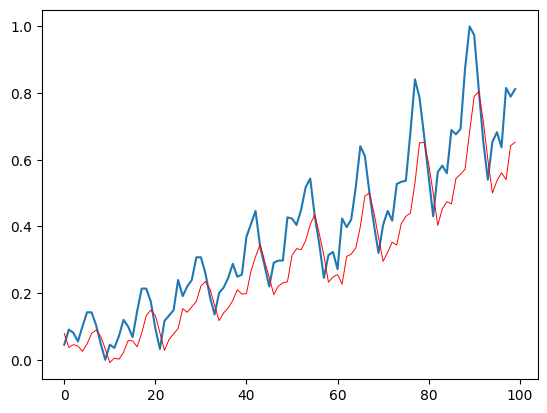

In [50]:
train_full_preds = lstm.predict(x_train_full)
print(f'Train Loss: {lstm.compute_loss(train_full_preds, y_train_full)}')
plt.plot(y_train_full[0, :, 0])
plt.plot(train_full_preds[0, :, 0], c='r', linewidth=0.7);

Baseline Test Loss: 0.134


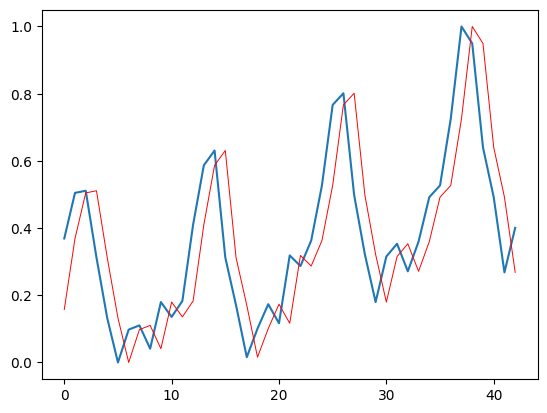

In [51]:
baseline_preds = x_test_full.copy()
print(f'Baseline Test Loss: {lstm.compute_loss(baseline_preds, y_test_full)}')
plt.plot(y_test_full[0, :, 0])
plt.plot(baseline_preds[0, :, 0], c='r', linewidth=0.7);

Test Loss: 0.163


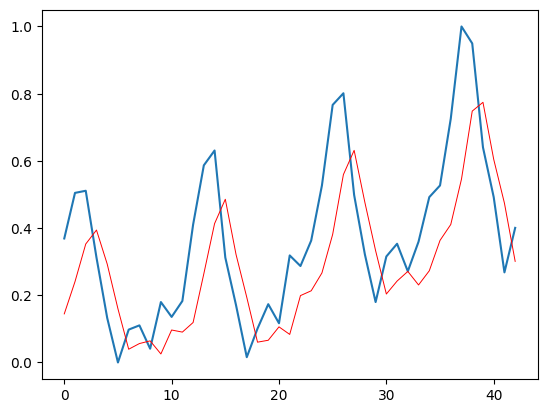

In [52]:
test_full_preds = lstm.predict(x_test_full)
print(f'Test Loss: {lstm.compute_loss(test_full_preds, y_test_full)}')
plt.plot(y_test_full[0, :, 0])
plt.plot(test_full_preds[0, :, 0], c='r', linewidth=0.7);

In [55]:
%%bash
jupyter nbconvert --to script 'RNNs_test.ipynb'

[NbConvertApp] Converting notebook RNNs_test.ipynb to script
[NbConvertApp] Writing 19753 bytes to RNNs_test.py
